In [1]:
from model import load_as_trt_model
from rchess import Board, Move
from utils import FakeTRTFunc
import numpy as np
from configs import engineplayConfig, selfplayConfig
from mcts import MCTS, debug_search, Node

use_fake = False
if use_fake:
    trt_func = FakeTRTFunc()
else:
    trt_func, _ = load_as_trt_model("latest")


2025-05-24 13:07:47.037156: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [2]:
mctsSearch = MCTS(engineplayConfig)
#mctsSearch = MCTS(selfplayConfig)

In [3]:
from chess import Board as PyBoard
board = Board()
board.push_uci("e2e4")
board.push_uci("e7e5")
board.push_uci("g1f3")
board.push_uci("b8c6")
#board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
#board = Board("6k1/8/8/3P4/8/8/8/K7 b - - 0 1")
#board = Board("2k5/5pn1/4P3/8/5Kn1/8/3R4/8 b - - 0 56")
pyBoard = PyBoard(board.fen())
#print(board)

In [79]:
move, root, child_visits = mctsSearch.find_best_move(board, None, trt_func, 0, 2.5, True)
debug_search(board, root, 3, 10)
board.push_num(move)
move_uci = Move(move).uci()
pyBoard.push_uci(move_uci)


  +---+---+---+---+---+---+---+---+
  | r |   |   |   |   |   |   | r | 8
  +---+---+---+---+---+---+---+---+
  |   | p | p |   | k | p | p | p | 7
  +---+---+---+---+---+---+---+---+
  | p |   |   | b |   |   |   |   | 6
  +---+---+---+---+---+---+---+---+
  |   |   |   |   |   |   |   |   | 5
  +---+---+---+---+---+---+---+---+
  |   |   | P |   |   |   |   |   | 4
  +---+---+---+---+---+---+---+---+
  | P |   |   |   |   |   |   |   | 3
  +---+---+---+---+---+---+---+---+
  |   | P |   |   |   | P | P | P | 2
  +---+---+---+---+---+---+---+---+
  |   | R | K | R |   |   |   |   | 1
  +---+---+---+---+---+---+---+---+
    a   b   c   d   e   f   g   h

Fen: r6r/1pp1kppp/p2b4/8/2P5/P7/1P3PPP/1RKR4 b - - 4 21
Key: 1130243a58398735
Elapsed time: 2.50s
Total visits: 23638
--------------------------------------------------------------------------------------------------------------
PV:
1. 0.756817 | a8d8 c1c2 d6h2 d1h1 h2f4 h1d1 g7g5 b2b3 e7e6
2. 0.730363 | h8d8 h2h3 d6c5 d1e1 e7f8 c1c2 

Move.from_uci('a8d8')

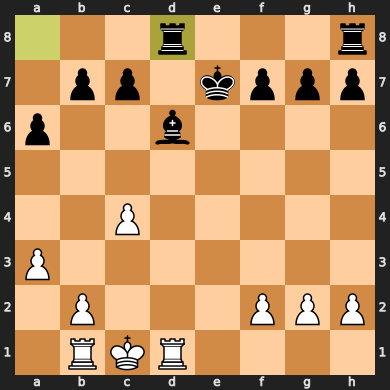

In [80]:
pyBoard

In [29]:
from model import predict_fn
board = Board("5k1r/1b2rp2/pR4pp/1p3n2/2p5/2N5/PP3PPP/3Q2K1 w - -")
image, hash = board.history(engineplayConfig["history_perspective_flip"])
value, policies = predict_fn(trt_func, np.array([image]))
print("Value:", value.numpy())
print("Policies:", policies.numpy())
# Max of policies and min of policies
policies = policies.numpy()[0]
print("Max policy:", np.max(policies))
print("Min policy:", np.min(policies))
print("Mean policy:", np.mean(policies))

Value: [[0.00239372]]
Policies: [[ 0.73828125  0.9121094   0.81933594 ... -0.3786621   0.89160156
   1.0566406 ]]
Max policy: 1.5595703
Min policy: -0.8125
Mean policy: 0.0023056436


In [1]:
from time_control import UniversalTimeControl

print("=== Bullet Chess: 60s start, 0 increment ===")
tc = UniversalTimeControl(move_overhead_ms=50)

examples = []
remaining_time = 60000  # Start with 60 seconds in ms
for move_num in range(1, 101, 1):
    move_time = tc.get_move_time(
        remaining_time_ms=remaining_time,
        increment_ms=0,
        has_pondered_ms=0,
        move_num=move_num
    )
    print(f"Move {move_num:3d}: remaining={remaining_time/1000:.2f}s, move_time={move_time:.3f}s")
    # Subtract the move time (converted to ms) for next iteration
    remaining_time -= int(move_time * 1000)
    if remaining_time < 0:
        remaining_time = 0

print("\n=== Bullet Chess: 60s start, 1s increment ===")
tc = UniversalTimeControl(move_overhead_ms=50)

remaining_time = 60000  # Reset to 60 seconds
for move_num in range(1, 101, 1):
    move_time = tc.get_move_time(
        remaining_time_ms=remaining_time,
        increment_ms=1000,
        has_pondered_ms=0,
        move_num=move_num
    )
    print(f"Move {move_num:3d}: remaining={remaining_time/1000:.2f}s, move_time={move_time:.3f}s")
    # Subtract the move time, add increment for next iteration
    remaining_time = remaining_time - int(move_time * 1000 ) + 1000
    if remaining_time < 0:
        remaining_time = 0

=== Bullet Chess: 60s start, 0 increment ===
Move   1: remaining=60.00s, move_time=1.035s
Move   2: remaining=58.97s, move_time=1.034s
Move   3: remaining=57.93s, move_time=1.033s
Move   4: remaining=56.90s, move_time=1.031s
Move   5: remaining=55.87s, move_time=1.030s
Move   6: remaining=54.84s, move_time=1.028s
Move   7: remaining=53.81s, move_time=1.026s
Move   8: remaining=52.79s, move_time=1.024s
Move   9: remaining=51.77s, move_time=1.021s
Move  10: remaining=50.74s, move_time=1.019s
Move  11: remaining=49.73s, move_time=1.016s
Move  12: remaining=48.71s, move_time=1.013s
Move  13: remaining=47.70s, move_time=1.010s
Move  14: remaining=46.69s, move_time=1.006s
Move  15: remaining=45.69s, move_time=1.002s
Move  16: remaining=44.68s, move_time=0.998s
Move  17: remaining=43.69s, move_time=0.994s
Move  18: remaining=42.69s, move_time=0.989s
Move  19: remaining=41.70s, move_time=0.984s
Move  20: remaining=40.72s, move_time=0.979s
Move  21: remaining=39.74s, move_time=0.973s
Move  22: 

[52.8, 51.92400000000001, 51.056, 50.196, 49.343999999999994, 48.5, 47.664, 46.836, 46.016000000000005, 45.204, 44.400000000000006, 43.604, 42.816, 42.036, 41.263999999999996, 40.5, 39.744, 38.995999999999995, 38.256, 37.524, 36.8, 36.084, 35.376, 34.676, 33.984, 33.3, 32.623999999999995, 31.956, 31.296, 30.644, 30.0, 29.364, 28.736, 28.116, 27.503999999999998, 26.9, 26.304, 25.716, 25.136, 24.564, 24.0, 23.444, 22.896, 22.355999999999998, 21.824, 21.3, 20.784, 20.276, 19.776, 19.284, 18.799999999999997, 18.323999999999998, 17.856, 17.396, 16.944000000000003, 16.5, 16.064, 15.636, 15.216, 14.804, 14.4, 14.004, 13.616, 13.236, 12.864, 12.5, 12.144, 11.796, 11.456, 11.123999999999999, 10.8, 10.484, 10.176, 9.876, 9.584, 9.3, 9.024000000000001, 8.756, 8.496, 8.244, 8.0, 7.764, 7.536, 7.316, 7.104, 6.9, 6.704000000000001, 6.516, 6.336, 6.164, 6.0, 5.844, 5.696, 5.556, 5.424, 5.300000000000001, 5.184, 5.076, 4.976, 4.884, 4.800000000000001, 4.724, 4.656000000000001, 4.596, 4.544000000000000

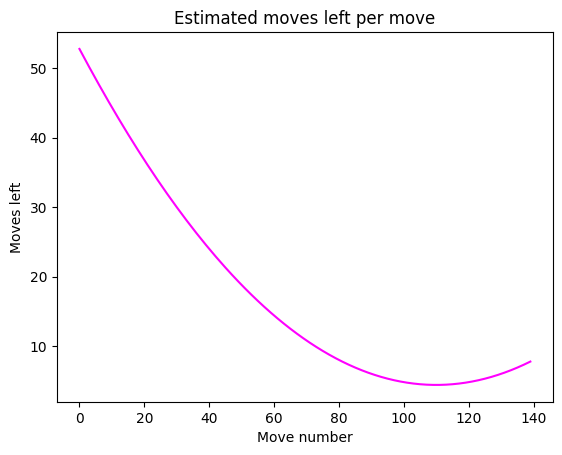

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def moves_left(move_num):
    a = 0.004
    b = -0.240
    h = 80
    k = 8
    return a * (move_num - h)**2 + b * (move_num - h) + k

x = np.arange(0, 140)
y = [moves_left(m) for m in x]
print(y)
plt.plot(x, y, color='magenta')
plt.xlabel("Move number")
plt.ylabel("Moves left")
plt.title("Estimated moves left per move")
plt.show()